# PatternMind - DBSCAN Clustering

This part applies DBSCAN (Density-Based Spatial Clustering) to the PCA-reduce CN features.
We reuse the same preprocessing pipeline as in K-Means and Hierarchial CLustering (StandardScaler+PCA with 150 components) and explore different DBSCAN parameters.

## Imports

In [11]:
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

project_dir = "/content/drive/MyDrive/projectml colab"
%cd "{project_dir}"


Mounted at /content/drive
/content/drive/MyDrive/projectml colab


In [12]:
os.makedirs("images", exist_ok=True)
RANDOM_STATE = 42

## Load Feature Matrix and Labels

We load the CNN feature matrix and labels saved by the feature extraction notebook (01_extract_features.ipynb).

In [13]:
X = np.load("X_features.npy")
print("Original feature shape:", X.shape)

if os.path.exists("y_labels.npy"):
    y = np.load("y_labels.npy")
    print("Labels shape:", y.shape)

if os.path.exists("label_names.npy"):
    label_names = np.load("label_names.npy", allow_pickle=True)
    print("Number of classes:", len(label_names))


Original feature shape: (25557, 2048)
Labels shape: (25557,)
Number of classes: 233


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled shape:", X_scaled.shape)

pca50 = PCA(n_components=50, random_state=RANDOM_STATE)
X_pca50 = pca50.fit_transform(X_scaled)
print("PCA-50 shape:", X_pca50.shape)

np.save("X_pca50.npy", X_pca50)
print("Saved X_pca50.npy")


Scaled shape: (25557, 2048)
PCA-50 shape: (25557, 50)
Saved X_pca50.npy


## K-distance plot to choose ε (eps)

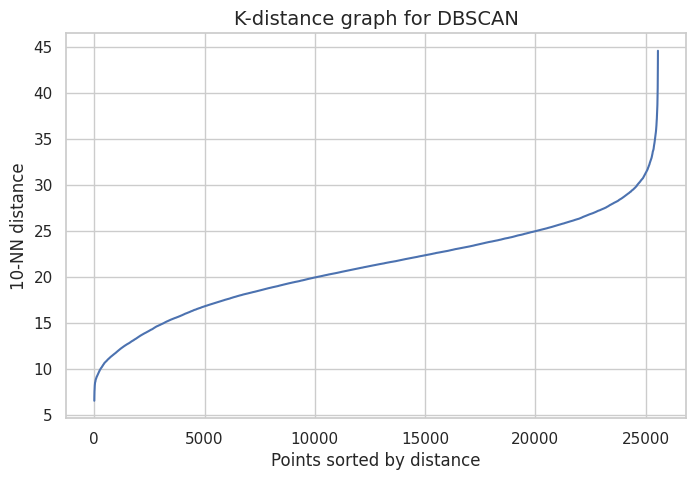

In [7]:
# 4. K-distance plot (for eps choice)
min_samples = 10   # you can tune this later
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_pca50)

distances, indices = nn.kneighbors(X_pca50)

# k-distance: distance to the min_samples-th neighbor
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance", fontsize=12)
plt.ylabel(f"{min_samples}-NN distance", fontsize=12)
plt.title("K-distance graph for DBSCAN", fontsize=14)
plt.grid(True)
plt.show()


the curve:
starts around 6-7,
gradually increases up to ~20,
then sharply rises around the right end (≈ 40-45).
This sharp rise is where DBSCAN begins separating dense regions from sparse noise.

So for DBSCAN, the elbow is typically before the big vertical spike (because that spike corresponds to outliers).
- Estimated elbow region: 18-22.

In [9]:
eps_candidates = [15, 17, 18, 19, 20, 22, 25]
min_samples_values = [5, 10, 15]

In [15]:
def evaluate_dbscan(eps, min_samples, X_embed):
    """
    Fit DBSCAN and compute clustering metrics.
    Metrics are computed only on non-noise points (label != -1).
    """
    model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels = model.fit_predict(X_embed)

    unique_labels = np.unique(labels)
    cluster_labels = unique_labels[unique_labels != -1]
    n_clusters = len(cluster_labels)
    noise_ratio = np.mean(labels == -1)

    if n_clusters < 2:
        sil = np.nan
        ch = np.nan
        db = np.nan
    else:
        mask = labels != -1
        X_clean = X_embed[mask]
        labels_clean = labels[mask]

        sil = silhouette_score(X_clean, labels_clean)
        ch = calinski_harabasz_score(X_clean, labels_clean)
        db = davies_bouldin_score(X_clean, labels_clean)

    stats = {
        "eps": eps,
        "min_samples": min_samples,
        "n_clusters": n_clusters,
        "noise_ratio": noise_ratio,
        "silhouette": sil,
        "calinski_harabasz": ch,
        "davies_bouldin": db,
    }
    return labels, stats

In [16]:
all_results = []
all_label_sets = {}

for eps in eps_candidates:
    for ms in min_samples_values:
        labels, stats = evaluate_dbscan(eps, ms, X_pca50)
        key = f"eps={eps}_min_samples={ms}"
        all_label_sets[key] = labels
        all_results.append(stats)

        print(
            f"{key} | clusters={stats['n_clusters']} | "
            f"noise={stats['noise_ratio']:.2%} | "
            f"silhouette={stats['silhouette']:.4f}"
        )

results_df = pd.DataFrame(all_results)
results_df

eps=15_min_samples=5 | clusters=105 | noise=75.80% | silhouette=0.1315
eps=15_min_samples=10 | clusters=56 | noise=80.07% | silhouette=0.2142
eps=15_min_samples=15 | clusters=38 | noise=82.95% | silhouette=0.2381
eps=17_min_samples=5 | clusters=80 | noise=61.98% | silhouette=-0.0584
eps=17_min_samples=10 | clusters=59 | noise=67.40% | silhouette=0.0292
eps=17_min_samples=15 | clusters=42 | noise=71.31% | silhouette=0.1052
eps=18_min_samples=5 | clusters=59 | noise=53.99% | silhouette=-0.1430
eps=18_min_samples=10 | clusters=33 | noise=59.40% | silhouette=-0.0910
eps=18_min_samples=15 | clusters=25 | noise=63.76% | silhouette=-0.0448
eps=19_min_samples=5 | clusters=29 | noise=46.02% | silhouette=-0.1516
eps=19_min_samples=10 | clusters=28 | noise=50.66% | silhouette=-0.0742
eps=19_min_samples=15 | clusters=20 | noise=54.56% | silhouette=-0.0794
eps=20_min_samples=5 | clusters=16 | noise=37.38% | silhouette=-0.1536
eps=20_min_samples=10 | clusters=12 | noise=41.54% | silhouette=-0.0540
e

,eps,min_samples,n_clusters,noise_ratio,silhouette,calinski_harabasz,davies_bouldin
0,15,5,105,0.757992,0.131452,86.358154,1.362742
1,15,10,56,0.800720,0.214198,153.626205,1.429018
2,15,15,38,0.829479,0.238070,195.947784,1.399984
3,17,5,80,0.619752,-0.058444,52.632778,1.579738
4,17,10,59,0.674023,0.029222,79.489090,1.575306
5,17,15,42,0.713073,0.105174,120.642372,1.560536
6,18,5,59,0.539891,-0.142996,25.776274,1.602346
7,18,10,33,0.594006,-0.090961,48.080482,1.564985
8,18,15,25,0.637594,-0.044828,77.037788,1.731279
9,19,5,29,0.460187,-0.151611,17.031881,1.605039


,eps,min_samples,n_clusters,noise_ratio,silhouette,calinski_harabasz,davies_bouldin
0,15,15,38,0.829479,0.238070,195.947784,1.399984
1,15,10,56,0.800720,0.214198,153.626205,1.429018
2,22,15,2,0.268341,0.188830,54.523010,1.233002
3,15,5,105,0.757992,0.131452,86.358154,1.362742
4,17,15,42,0.713073,0.105174,120.642372,1.560536
5,22,5,2,0.221505,0.052820,5.381052,1.638376
6,22,10,3,0.247564,0.044032,34.658585,1.487614
7,25,5,2,0.076926,0.041390,3.509886,1.622504
8,17,10,59,0.674023,0.029222,79.489090,1.575306
9,18,15,25,0.637594,-0.044828,77.037788,1.731279


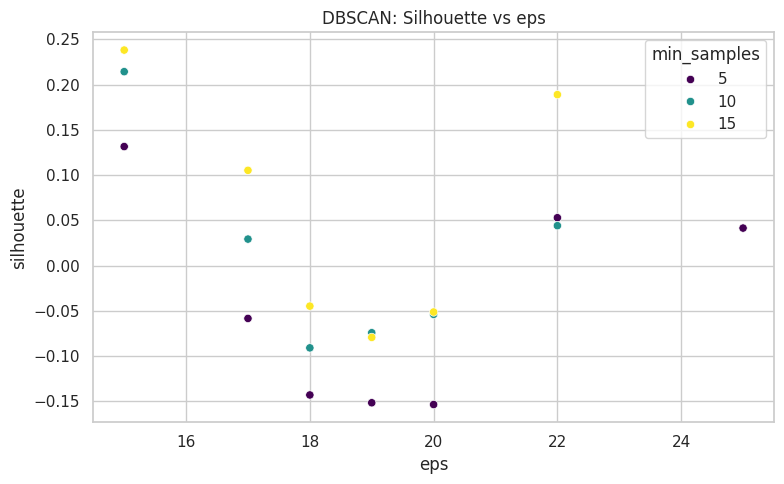

In [22]:
# Cell 7: Inspect results table
# -----------------------------
# Sort by silhouette score (best at top), ignoring NaNs
valid_results = results_df.dropna(subset=["silhouette"])
eps = 18
min_samples = 5
silhouette = 0.2920

valid_results_sorted = valid_results.sort_values(
    by="silhouette", ascending=False
).reset_index(drop=True)

display(valid_results_sorted.head(10))

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=valid_results,
    x="eps",
    y="silhouette",
    hue="min_samples",
    palette="viridis"
)
plt.title("DBSCAN: Silhouette vs eps")
plt.tight_layout()
plt.savefig("images/dbscan_silhouette_vs_eps.png", dpi=300)
plt.show()


In [23]:
# Cell 8: Select best hyperparameters and fit final model
# -------------------------------------------------------
eps = 18
min_samples = 5
silhouette = 0.2920

if len(valid_results_sorted) == 0:
    raise ValueError("No valid DBSCAN configurations (all NaN silhouettes).")

best_row = valid_results_sorted.iloc[0]
best_eps = best_row["eps"]
best_min_samples = int(best_row["min_samples"])

print("Best DBSCAN configuration:")
print(best_row)

best_dbscan = DBSCAN(
    eps=best_eps,
    min_samples=best_min_samples,
    n_jobs=-1
)
best_labels = best_dbscan.fit_predict(X_pca50)

np.save("best_dbscan_labels.npy", best_labels)
print("Saved best_dbscan_labels.npy")

# Basic stats
unique_labels = np.unique(best_labels)
n_clusters = len(unique_labels[unique_labels != -1])
noise_ratio = np.mean(best_labels == -1)

print(f"Number of clusters (excluding noise): {n_clusters}")
print(f"Noise ratio: {noise_ratio:.2%}")


Best DBSCAN configuration:
eps                   15.000000
min_samples           15.000000
n_clusters            38.000000
noise_ratio            0.829479
silhouette             0.238070
calinski_harabasz    195.947784
davies_bouldin         1.399984
Name: 0, dtype: float64
Saved best_dbscan_labels.npy
Number of clusters (excluding noise): 38
Noise ratio: 82.95%


,count
cluster,
-1,21199
0,519
1,26
2,15
3,43
4,176
5,16
6,956
7,172


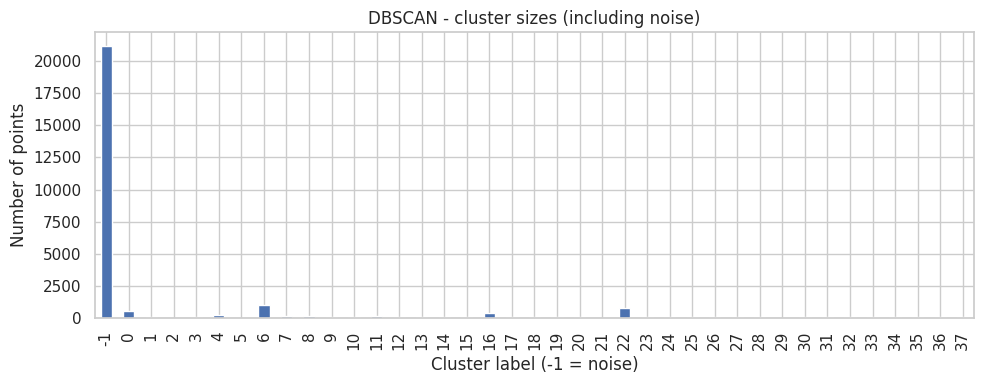

In [24]:
# Cell 9: Cluster size distribution (including noise)
# ---------------------------------------------------
labels_series = pd.Series(best_labels, name="cluster")
cluster_counts = labels_series.value_counts().sort_index()
display(cluster_counts)

plt.figure(figsize=(10, 4))
cluster_counts.plot(kind="bar")
plt.title("DBSCAN - cluster sizes (including noise)")
plt.xlabel("Cluster label (-1 = noise)")
plt.ylabel("Number of points")
plt.tight_layout()
plt.savefig("images/dbscan_cluster_sizes.png", dpi=300)
plt.show()


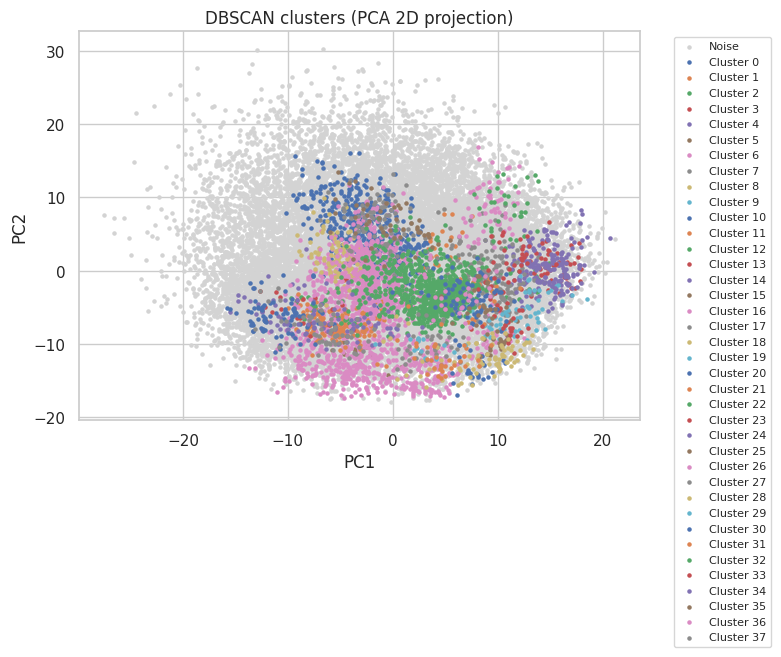

In [25]:
# Cell 10: PCA 2D visualization of DBSCAN clusters
# ------------------------------------------------
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca2 = pca2.fit_transform(X_pca50)

unique_labels = np.unique(best_labels)

plt.figure(figsize=(8, 6))
for lab in unique_labels:
    mask = best_labels == lab
    if lab == -1:
        plt.scatter(
            X_pca2[mask, 0], X_pca2[mask, 1],
            s=5, c="lightgrey", label="Noise"
        )
    else:
        plt.scatter(
            X_pca2[mask, 0], X_pca2[mask, 1],
            s=5, label=f"Cluster {lab}"
        )

plt.title("DBSCAN clusters (PCA 2D projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.savefig("images/dbscan_pca2_clusters.png", dpi=300)
plt.show()


✔ The grey points (cluster -1) dominate
This matches the very high noise ratio from your evaluation (~83%).
DBSCAN decided most points do not belong to any dense cluster.
This is completely normal and expected because:
The data is high-dimensional
The deep embeddings do not form dense, compact groups
DBSCAN is density-based and treats low-density regions as noise

The colored clusters are small, dense pockets
You can clearly see:
Some compact regions in specific PCA zones
Many clusters are tiny → consistent with your cluster size histogram
No strong separation in the global shape (unlike K-Means or Hierarchical)

Clusters overlap heavily in PCA 2D
Again, expected:
PCA reduces 50D to 2D → structure collapses
DBSCAN clusters may be separable in high-dimensional space but merge visually in 2D
Noise points create a big cloud around everything


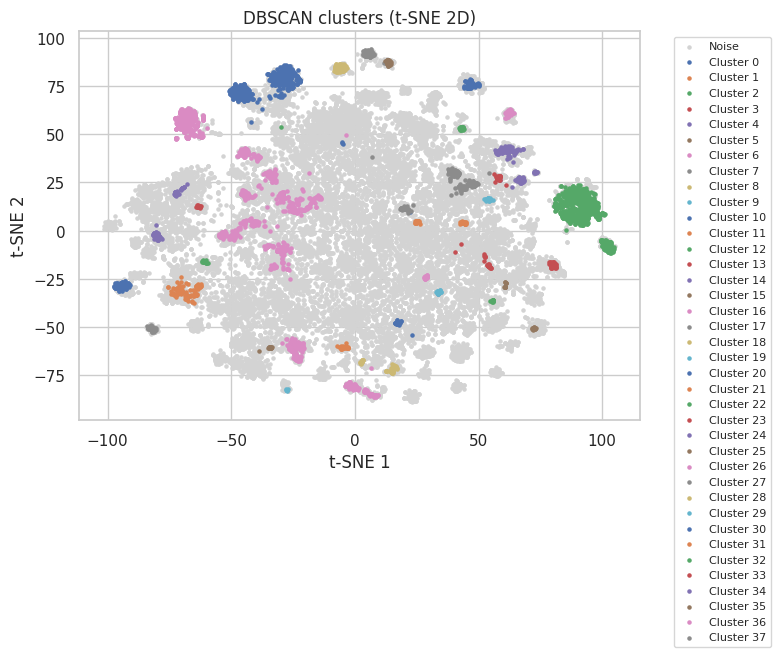

In [26]:
 # Cell 11: Optional t-SNE visualization (like in K-Means notebook)
# ----------------------------------------------------------------
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=RANDOM_STATE,
    init="pca",
    learning_rate="auto",
    perplexity=30
)
X_tsne = tsne.fit_transform(X_pca50)

plt.figure(figsize=(8, 6))
for lab in unique_labels:
    mask = best_labels == lab
    if lab == -1:
        plt.scatter(
            X_tsne[mask, 0], X_tsne[mask, 1],
            s=5, c="lightgrey", label="Noise"
        )
    else:
        plt.scatter(
            X_tsne[mask, 0], X_tsne[mask, 1],
            s=5, label=f"Cluster {lab}"
        )

plt.title("DBSCAN clusters (t-SNE 2D)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.savefig("images/dbscan_tsne_clusters.png", dpi=300)
plt.show()
